# Classification of IRIS by Quantum Neural Network

Translator: [unseenme](https://gitee.com/unseenme)

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/en/case_library/mindspore_classification_of_iris_by_qnn.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/en/case_library/mindspore_classification_of_iris_by_qnn.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.7.0rc1/docs/mindquantum/docs/source_en/case_library/classification_of_iris_by_qnn.ipynb)

## Overview

Quantum neural network is a type of algorithm that combines artificial neural networks with quantum computing. In classical neural networks, we use a network structure similar to the human brain nervous system as a computing model to predict specific problems, optimize the parameters of neurons based on real world information, and iterate repeatedly until the model can predict the results accurately. In quantum circuits, we can also build a similar network structure and use some parameter gates as neurons. Then we can measure to get the expectation of the relevant Hamiltonian as a loss function and optimize the gate parameters until find the optimal parameters. In this way, we have trained a quantum neural network. Quantum parallelism or quantum entanglement has the potential to bring advantages to quantum neural networks, but there is currently no evidence that quantum neural networks are superior to classical neural networks. A typical quantum neural network includes Encoder and Ansatz. Encoder can encode classical data into quantum states. Common encoding methods include amplitude encoding, phase encoding, and IQP encoding. Ansatz can give prediction results based on input. Common Ansatz includes [Hardware Efficient Ansatz](https://www.mindspore.cn/mindquantum/docs/en/r0.11/algorithm/nisq/mindquantum.algorithm.nisq.HardwareEfficientAnsatz.html), [Strongly Entangling Ansatz](https://www.mindspore.cn/mindquantum/docs/en/r0.11/algorithm/nisq/mindquantum.algorithm.nisq.StronglyEntangling.html), etc.

In the previous tutorial, we introduced what a variational quantum circuit is, and experienced how to build a quantum neural network to solve a small problem by a simple example. In this tutorial, we will experience the upgrade, and will introduce how to solve problems in classical machine learning by building quantum neural networks. The problem we choose is: Iris classification problem in supervised learning.

Problem description: The iris dataset is a commonly used dataset in classical machine learning. The dataset contains a total of 150 samples (divided into 3 different subgenus: setosa, versicolor and virginica, 50 samples for each subgenus), each sample contains 4 features, sepal length, sepal width, petal length and petal width.

We selected the first 100 samples (setosa and versicolor), and randomly selected 80 samples as the training set, and trained the quantum classifier (Ansatz) by building a quantum neural network. After training, the classification test is performed on the remaining 20 samples, and the prediction accuracy is expected to be as high as possible.

Idea: We need to divide the 100 samples into 80 training samples and 20 test samples, calculate the parameters required to build the encoder according to the classical data of the training samples, and then build the encoder to encode the classical data of the training samples into quantum state, then, build Ansatz, train the parameters in Ansatz by the built quantum neural network layer and MindSpore operator, to obtain the final classifier, and finally, classify the remaining 20 test samples to obtain predictions's accuracy.

## Environment Preparation

First, we need to import the iris dataset, and before importing the dataset, we need to use the datasets module in the sklearn library, so the reader needs to check whether the sklearn library is installed, and for checking, we can execute the following code.

```bash
pip show scikit-learn
```

If no error is reported, it means it has been installed. To briefly explain, sklearn is the abbreviation of scikit-learn, which is a third-party module based on Python. The sklearn library integrates some common machine learning methods. When performing machine learning tasks, there is no need to implement algorithms. Most machine learning tasks can be completed by simply calling the modules provided in the sklearn library.

If the sklearn library is not installed, it can be installed by running the following code.

```bash
pip install scikit-learn
```

In [1]:
import numpy as np                                        # Import the numpy library and abbreviated as np
from sklearn import datasets                              # Import datasets module for loading iris datasets

iris_dataset = datasets.load_iris()                       # Load the iris dataset and save to iris_dataset

print(iris_dataset.data.shape)                            # Print the data dimensions of the samples of iris_dataset
print(iris_dataset.feature_names)                         # Print the feature names of the samples of iris_dataset
print(iris_dataset.target_names)                          # Print the subgenus names contained in the samples of iris_dataset
print(iris_dataset.target)                                # print an array of labels for the samples of iris_dataset
print(iris_dataset.target.shape)                          # Print the data dimension of the labels of the samples of iris_dataset

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150,)


As can be seen from the above print, the dataset has a total of 150 samples, and each sample has 4 features: sepal length, sepal width, petal length and petal width. And the sample contains 3 different subgenera: setosa, versicolor and virginica, each sample has a corresponding classification number, 0 means the sample belongs to setosa, 1 means the sample belongs to versicolor, 2 means the sample belongs to virginica, so there is an array of 150 numbers to represent the subgenus type of the sample.

Since we only select the first 100 samples, execute the following command.

In [2]:
X = iris_dataset.data[:100, :].astype(np.float32)         # Select the first 100 data of the data of iris_dataset, convert its data type to float32, and store it in X
X_feature_names = iris_dataset.feature_names              # Store the feature names of iris_dataset in X_feature_names
y = iris_dataset.target[:100].astype(int)                 # Select the first 100 data of the target of iris_dataset, convert its data type to int, and store it in y
y_target_names = iris_dataset.target_names[:2]            # Select the first 2 data of target_names of iris_dataset and store them in y_target_names

print(X.shape)                                            # Data dimensions for print samples
print(X_feature_names)                                    # feature name of the print sample
print(y_target_names)                                     # Subgenus names included in the print sample
print(y)                                                  # an array of labels to print the samples
print(y.shape)                                            # Data dimension of labels for printing samples

(100, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(100,)


As can be seen from the above print, there are only 100 samples in the dataset X at this time, and each sample still has 4 features, which are still sepal length, sepal width, petal length and petal width. At this time, there are only 2 different subgenera: setosa and versicolor, and each sample has a corresponding classification number, 0 means it belongs to setosa, 1 means it belongs to versicolor, so there is an array of 100 numbers to represent the subgenus type of the sample.

## Data Visualization

In order to understand the data set composed of these 100 samples more intuitively, we draw a scatter plot composed of different features of all samples, and execute the following command.


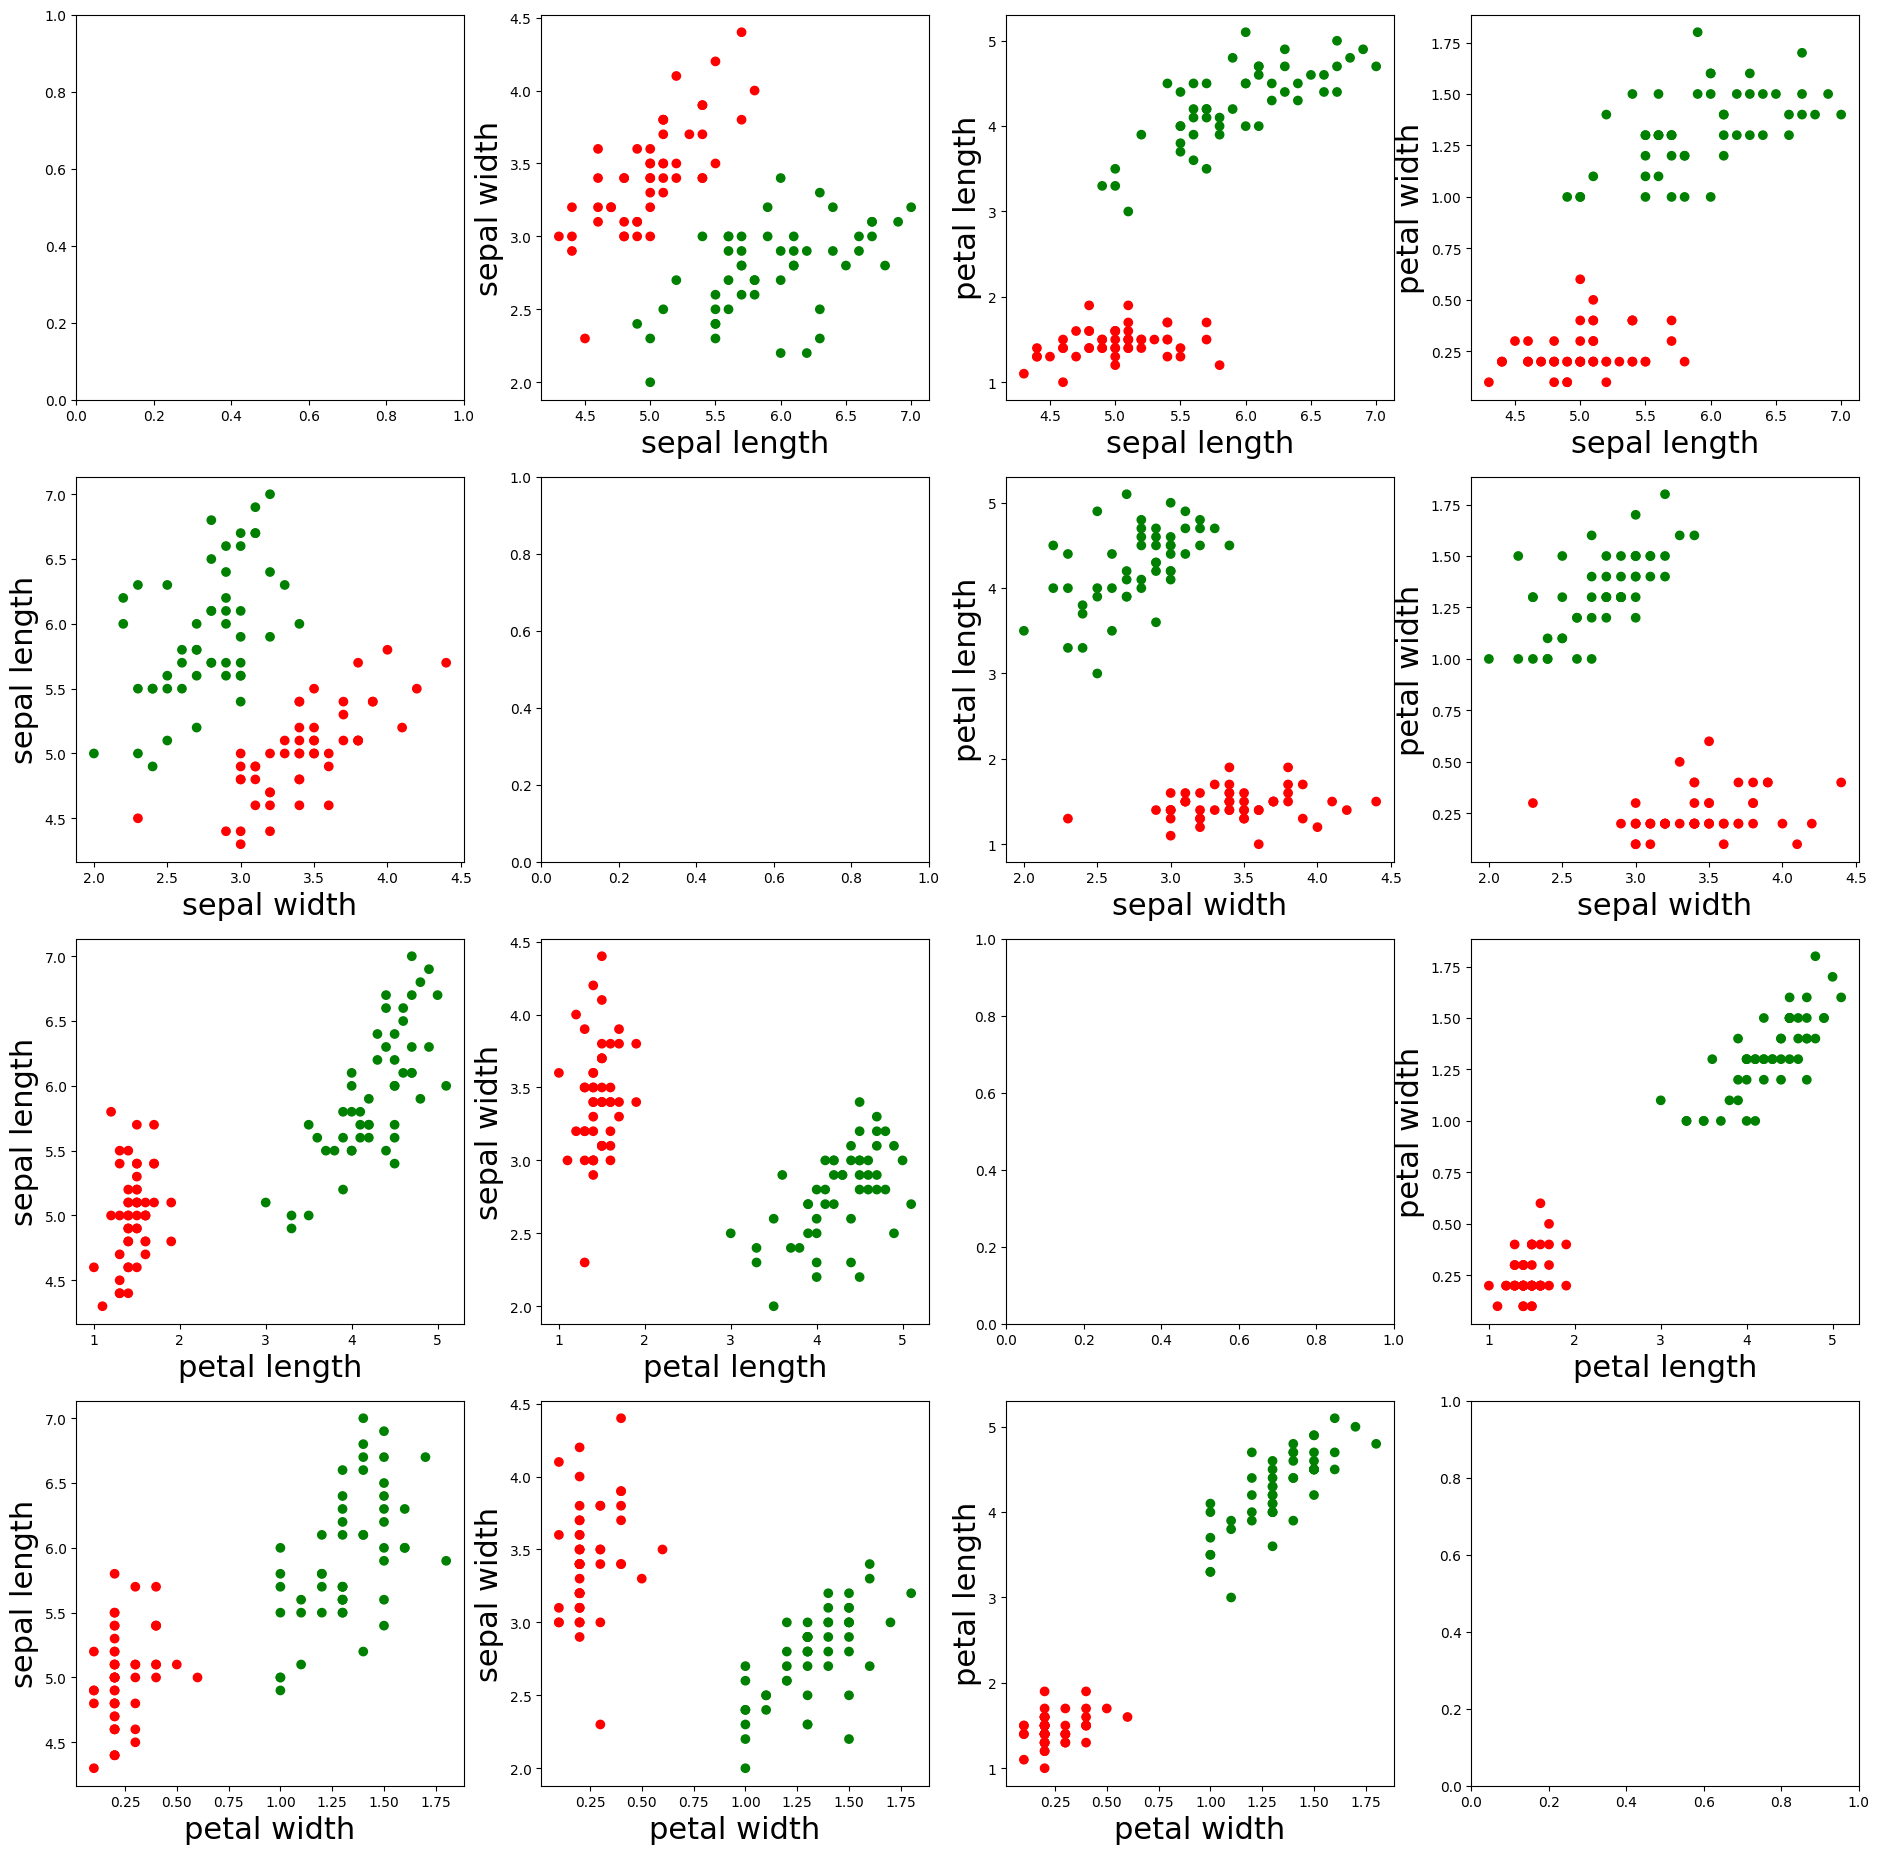

In [3]:
import matplotlib.pyplot as plt                                                           # Import the matplotlib.pyplot module and abbreviated to plt

feature_name = {0: 'sepal length', 1: 'sepal width', 2: 'petal length', 3: 'petal width'} # Label the different feature names as 0, 1, 2, 3
axes = plt.figure(figsize=(23, 23)).subplots(4, 4)                                        # Draw a graph of size 23*23, including 4*4=16 subgraphs

colormap = {0: 'r', 1: 'g'}                                                               # Make the sample with label 0 red and the sample with label 1 green
cvalue = [colormap[i] for i in y]                                                         # Set the corresponding color of the label corresponding to 100 samples

for i in range(4):
    for j in range(4):
        if i != j:
            ax = axes[i][j]                                                               # Start drawing on the subgraph of [i][j]
            ax.scatter(X[:, i], X[:, j], c=cvalue)                                        # Draw a scatterplot of the [i]th feature and the [j]th feature
            ax.set_xlabel(feature_name[i], fontsize=22)                                   # Set the name of the X-axis to the [i]th feature name and the font size to 22
            ax.set_ylabel(feature_name[j], fontsize=22)                                   # Set the name of the Y-axis to the [j]th feature name and font size to 22
plt.show()                                                                                # render the image

As can be seen from the images presented above, the red dots represent the samples with the label "0", and the green dots represent the samples with the label "1". In addition, we found that the different characteristics of the two types of samples are relatively easy to distinguish.

## Data Preprocessing

Next, we need to calculate the parameters used to build the Encoder, and then divide the data set into training set and test set, and execute the following command.


In [4]:
alpha = X[:, :3] * X[:, 1:]           # In each sample, a parameter is calculated using two adjacent feature values, that is, each sample will have 3 more parameters (because there are 4 feature values), and stored in alpha
X = np.append(X, alpha, axis=1)       # In the dimension of axis=1, add the data values of alpha to the feature values of X

print(X.shape)                        # Print the data dimension of the sample of X at this time

(100, 7)


It can be seen from the above print that there are still 100 samples in the dataset [X](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/gates/mindquantum.core.gates.XGate.html) at this time, but each sample has 7 features at this time, the first 4 feature values are the original feature values, and the last 3 feature values are the ones calculated by the above preprocessing. The specific calculation formula is as follows:

$$ X_{i+4}^{j} = X_{i}^{j} * X_{i+1}^{j}, i=0,1,2,j=1,2,...,100. $$

Finally, we divide the data set at this time into training set and test set, and execute the following command.

In [5]:
from sklearn.model_selection import train_test_split                                                   # Import the train_test_split function for dividing the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True) # Divide the dataset into training and test sets

print(X_train.shape)                                                                                   # Print the data type of the samples in the training set
print(X_test.shape)                                                                                    # Print the data type of the samples in the test set

(80, 7)
(20, 7)


As can be seen from the above print, the training set at this time has 80 samples, the test set has 20 samples, and each sample has 7 features.

Note:

(1) append is mainly used to add some values ​​to the original array. The general format is as follows: np.append(arr, values, axis=None), `arr` is the array which the value needs to be added to, and `values` ​​is the value added to the array `arr`, `axis` indicates in which direction;

(2) `shuffle=True` means that the data set is shuffled and returned in a different order each time. `Shuffle` is to avoid the impact of the order of data input on network training. Increase the randomness, improve the generalization performance of the network, avoid the gradient of weight update being too extreme due to the appearance of regular data, and avoid overfitting or underfitting of the final model.

(3) `train_test_split` is a commonly used function in cross-validation. It is mainly used to randomly select training data sets and test data sets in proportion from samples. The general format is as follows: `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size , random_state, shuffle=True)`, `test_size` represents the proportion of test samples, `random_state` represents the seed for generating random numbers, and `shuffle=True` represents shuffling the dataset.

## Building Encoder

According to the quantum circuit diagram shown, we can build an Encoder in MindSpore Quantum to encode classical data into quantum states.

![encoder classification of iris by qnn](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/docs/mindquantum/docs/source_en/images/encoder_classification_of_iris_by_qnn.png)

Here, the encoding method we use is [IQP encoding](https://www.mindspore.cn/mindquantum/docs/en/r0.11/algorithm/nisq/mindquantum.algorithm.nisq.IQPEncoding.html) (Instantaneous Quantum Polynomial encoding). Generally speaking, the encoding method of the Encoder is not fixed, and different encoding methods can be selected according to the needs of the problem, and sometimes the Encoder will be adjusted according to the final performance.

The values of the parameters $\alpha_0,\alpha_1,...,\alpha_6$​ in the Encoder are substituted with the 7 feature values obtained in the above data preprocessing. ​

                                 Circuit Summary                                 
╭──────────────────────┬────────────────────────────────────────────────────────╮
│ Info                 │ value                                                  │
├──────────────────────┼────────────────────────────────────────────────────────┤
│ Number of qubit      │ 4                                                      │
├──────────────────────┼────────────────────────────────────────────────────────┤
│ Total number of gate │ 17                                                     │
│ Barrier              │ 0                                                      │
│ Noise Channel        │ 0                                                      │
│ Measurement          │ 0                                                      │
├──────────────────────┼────────────────────────────────────────────────────────┤
│ Parameter gate       │ 7                                                      │
│ 7 ansatz parameters  │ alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 │
╰──────────────────────┴────────────────────────────────────────────────────────╯

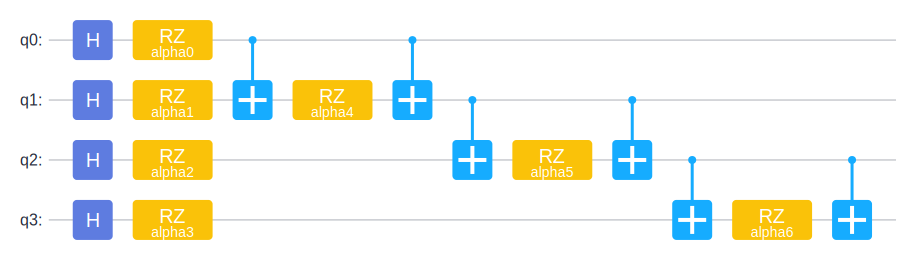

In [6]:
# pylint: disable=W0104
from mindquantum.core.circuit import Circuit
from mindquantum.core.circuit import UN
from mindquantum.core.gates import H, X, RZ
from mindquantum.core.parameterresolver import PRGenerator

prg = PRGenerator('alpha')
encoder = Circuit()
encoder += UN(H, 4)                                  # H gates act on every 1 qubit
for i in range(4):                                   # i = 0, 1, 2, 3
    encoder += RZ(prg.new()).on(i)                   # The RZ(alpha_i) gate acts on the ith qubit
for j in range(3):                                   # j = 0, 1, 2
    encoder += X.on(j+1, j)                          # The X gate acts on the j+1th qubit and is controlled by the jth qubit
    encoder += RZ(prg.new()).on(j+1)                 # The RZ(alpha_{j+4}) gate acts on the 0th qubit
    encoder += X.on(j+1, j)                          # The X gate acts on the j+1th qubit and is controlled by the jth qubit

encoder = encoder.no_grad()                          # As the first layer of the entire quantum neural network, the Encoder does not need to take the derivative of the gradient in the encoding circuit, so no_grad() is added.
encoder.summary()                                    # Summary Encoder
encoder.svg()

As can be seen from the summary of the Encoder, the quantum circuit consists of 17 quantum gates, of which 7 contain parameter quantum gates and the parameters are $\alpha_0,\alpha_1,...,\alpha_6$, and the number of qubits regulated by the quantum circuit is 4.

Note:

The [UN](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/circuit/mindquantum.core.circuit.UN.html) module is used to map quantum gates to different target qubits and control qubits. The general format is as follows: `mindquantum.circuit.UN(gate, maps_obj, maps_ctrl=None)`, the gate in parentheses is the quantum gate we need to execute, `maps_obj` is the target qubit that needs to execute the quantum gate, `maps_ctrl` is the control qubit, if it is `None`, there is no control qubit. If each qubit implements the same nonparametric quantum gate, `UN(gate, N)` can be written directly, where `N` represents the number of qubits.

## Building Ansatz

According to the [quantum circuit](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html) diagram shown, we can build Ansatz in MindSpore Quantum.

![ansatz classification of iris by qnn](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/docs/mindquantum/docs/source_en/images/ansatz_classification_of_iris_by_qnn.png)

Like Encoder, Ansatz's encoding method is not fixed, and we can try different encoding methods to test the final result.

Here, we use [HardwareEfficientAnsatz](https://www.mindspore.cn/mindquantum/docs/en/r0.11/algorithm/nisq/mindquantum.algorithm.nisq.HardwareEfficientAnsatz.html), the encoding method shown in the above quantum circuit diagram.

                                       Circuit Summary                                       
╭──────────────────────┬────────────────────────────────────────────────────────────────────╮
│ Info                 │ value                                                              │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Number of qubit      │ 4                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Total number of gate │ 25                                                                 │
│ Barrier              │ 0                                                                  │
│ Noise Channel        │ 0                                                                  │
│ Measurement          │ 0                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Parameter gate       │ 16                                                                 │
│ 16 ansatz parameters │ d0_n0_0, d0_n1_0, d0_n2_0, d0_n3_0, d1_n0_0, d1_n1_0, d1_n2_0,     │
│                      │ d1_n3_0, d2_n0_0, d2_n1_0...                                       │
╰──────────────────────┴────────────────────────────────────────────────────────────────────╯

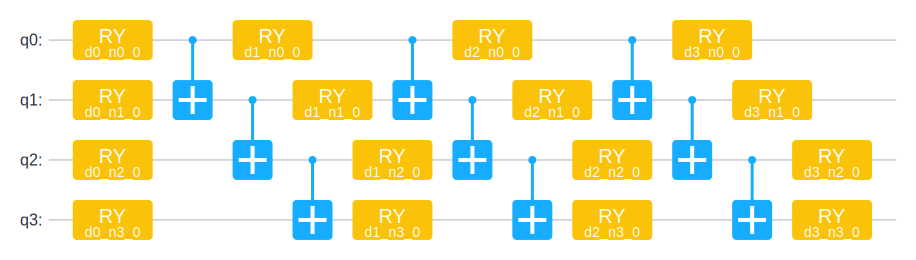

In [7]:
# pylint: disable=W0104
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz                                      # Import HardwareEfficientAnsatz
from mindquantum.core.gates import RY                                                               # Import quantum gate RY

ansatz = HardwareEfficientAnsatz(4, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit     # Building Ansatz with HardwareEfficientAnsatz
ansatz.summary()                                                                                    # Summary Ansatz
ansatz.svg()

As can be seen from the summary of Ansatz, the quantum circuit consists of 25 quantum gates, of which 16 contain parameter quantum gates with parameters d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0 ..., the number of qubits regulated by the quantum circuit is 4.

Note:

[HardwareEfficientAnsatz](https://www.mindspore.cn/mindquantum/docs/en/r0.11/algorithm/nisq/mindquantum.algorithm.nisq.HardwareEfficientAnsatz.html) is an Ansatz that is easy to implement on quantum chips. Its quantum circuit diagram consists of quantum gates in the red dashed box. The general format is as follows: `mindquantum.ansatz.HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, entangle_gate=X, entangle_mapping="linear" , depth=1)`, `n_qubits` in parentheses represents the total number of qubits that Ansatz needs to act on, `single_rot_gate_seq` represents the parameter gate executed by each qubit at the beginning, and the parameter gate that needs to be executed later is also fixed, but the parameters are different, `entangle_gate=X` indicates that the executed entanglement gate is X, `entangle_mapping="linear"` indicates that the entanglement gate will act on each pair of adjacent qubits, and `depth` indicates the number of times the quantum gate in the black dashed box needs to be repeated.

Then the complete quantum circuit is Encoder plus Ansatz. Here we call [as_encoder](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.as_encoder) to convert all parameters to encoder parameters and call [as_ansatz](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.as_ansatz) to convert all parameters to trainable ansatz parameters.

                                       Circuit Summary                                       
╭──────────────────────┬────────────────────────────────────────────────────────────────────╮
│ Info                 │ value                                                              │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Number of qubit      │ 4                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Total number of gate │ 42                                                                 │
│ Barrier              │ 0                                                                  │
│ Noise Channel        │ 0                                                                  │
│ Measurement          │ 0                                                                  │
├──────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Parameter gate       │ 23                                                                 │
│ 7 encoder parameters │ alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6             │
│ 16 ansatz parameters │ d0_n0_0, d0_n1_0, d0_n2_0, d0_n3_0, d1_n0_0, d1_n1_0, d1_n2_0,     │
│                      │ d1_n3_0, d2_n0_0, d2_n1_0...                                       │
╰──────────────────────┴────────────────────────────────────────────────────────────────────╯

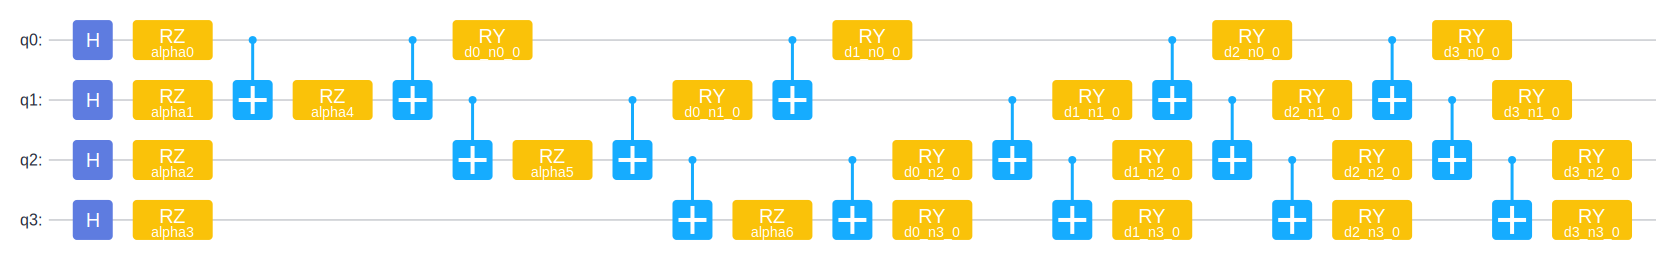

In [8]:
# pylint: disable=W0104
circuit = encoder.as_encoder() + ansatz.as_ansatz()                   # The complete quantum circuit consists of Encoder and Ansatz
circuit.summary()
circuit.svg()

From the summary of the complete quantum circuit, it can be seen that the quantum circuit consists of 42 quantum gates, of which 23 contain parameter quantum gates with parameters $\alpha_0,\alpha_1,...,\alpha_6$ and d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0..., the number of qubits controlled by this quantum circuit is 4.

## Building the Hamiltonian

We perform Pauli Z operator measurements on the 2nd and 3rd qubits respectively, to construct the corresponding [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/en/r0.11/core/operators/mindquantum.core.operators.Hamiltonian.html).

In [9]:
from mindquantum.core.operators import QubitOperator                     # Import the QubitOperator module for constructing the Pauli operator
from mindquantum.core.operators import Hamiltonian                       # Import the Hamiltonian module for building the Hamiltonian

hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [2, 3]]   # Perform the Pauli Z operator measurement on the 2nd and 3rd qubits respectively, and set the coefficients to 1 to construct the corresponding Hamiltonian
for h in hams:
    print(h)

1 [Z2]
1 [Z3]


It can be seen from the above print that there are 2 Hamiltonians constructed at this time, which are to perform the Pauli Z operator on the second and third qubits respectively, and set the coefficients to 1. We can obtain 2 Hamiltonian measurement values by the Pauli Z operator measurement. If the first measurement value is larger, the sample will be classified into the class labeled "0". Similarly, if the second measurement value is larger, this sample will be classified into the class with the label "1". By the training of the neural network, it is expected that the 1st measurement value of the sample labeled "0" in the training sample is larger, and the 2nd measurement value of the sample labeled "1" is larger, and finally this model is applied to predict the classification of new samples.

## Building a Quantum Neural Network

In [10]:
# pylint: disable=W0104
import mindspore as ms                                            # Import the mindspore library and abbreviated as ms
from mindquantum.framework import MQLayer                         # Import MQLayer
from mindquantum.simulator import Simulator

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)                                                    # Set the seed for generating random numbers
sim = Simulator('mqvector', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)                                    # Building a quantum neural network
QuantumNet

MQLayer<
  (evolution): MQOps<4 qubits mqvector VQA Operator>
  >

As can be seen from the above printing, we have successfully built a quantum machine learning layer, which can seamlessly form a larger machine learning network with other operators in MindSpore.

Note:

MindSpore is an all-scenario deep learning framework that aims to achieve the three goals of easy development, efficient execution, and unified deployment for all scenarios. It provides tensor differentiable programming capabilities that support heterogeneous acceleration, and also supports cloud, server, edge and end multiple hardware platforms.

## Training

Next, we need to define the loss function, set the parameters to be optimized, and then combine the built quantum machine learning layer and MindSpore's operators to form a larger machine learning network, and finally train the model.

In [11]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # Import the SoftmaxCrossEntropyWithLogits module to define the loss function
from mindspore.nn import Adam                                                  # Import the Adam module, which is used to define optimization parameters.
from mindspore.train import Accuracy, Model, LossMonitor                       # Import the Accuracy module, which is used to evaluate the prediction accuracy respectively.
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset                               # Import the NumpySlicesDataset module for creating datasets that the model can recognize

loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # The loss function is defined by SoftmaxCrossEntropyWithLogits, sparse=True indicates that the specified label uses a sparse format, and reduction='mean' indicates that the dimensionality reduction method of the loss function is averaging
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.1)                  # The parameters in Ansatz are optimized by the Adam optimizer. What needs to be optimized are the trainable parameters in Quantumnet, and the learning rate is set to 0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # Build a model: Combine the quantum machine learning layer built by MindSpore Quantum and the operators of MindSpore to form a larger machine learning network

train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(5) # Create a dataset of training samples by NumpySlicesDataset, shuffle=False means not to shuffle the data, batch(5) means that the training set has 5 sample points per batch
test_loader = NumpySlicesDataset({'features': X_test, 'labels': y_test}).batch(5)                   # Create a data set of test samples by NumpySlicesDataset, batch(5) means that there are 5 sample points in each batch of the test set

class StepAcc(ms.Callback):                                                        # Define a callback function about the accuracy of each step
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def on_train_step_end(self, run_context):
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])

monitor = LossMonitor(16)                                                       # Monitor the loss during training and print the loss value every 16 steps
acc = StepAcc(model, test_loader)                                               # Calculate the accuracy of predictions using the established model and test samples
model.train(20, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# Train the model 20 times

epoch: 1 step: 16, loss is 0.5612059831619263
epoch: 2 step: 16, loss is 0.4522572159767151
epoch: 3 step: 16, loss is 0.41864094138145447
epoch: 4 step: 16, loss is 0.3906601667404175
epoch: 5 step: 16, loss is 0.38612788915634155
epoch: 6 step: 16, loss is 0.38768959045410156
epoch: 7 step: 16, loss is 0.38906118273735046
epoch: 8 step: 16, loss is 0.3899310231208801
epoch: 9 step: 16, loss is 0.3907302916049957
epoch: 10 step: 16, loss is 0.3917989134788513
epoch: 11 step: 16, loss is 0.3922387659549713
epoch: 12 step: 16, loss is 0.39297252893447876
epoch: 13 step: 16, loss is 0.39348381757736206
epoch: 14 step: 16, loss is 0.3938162922859192
epoch: 15 step: 16, loss is 0.39411014318466187
epoch: 16 step: 16, loss is 0.3943289518356323
epoch: 17 step: 16, loss is 0.39446941018104553
epoch: 18 step: 16, loss is 0.3945646286010742
epoch: 19 step: 16, loss is 0.3946278691291809
epoch: 20 step: 16, loss is 0.3946625292301178


As can be seen from the above print, after 20 iterations, the loss value keeps decreasing and tends to stabilize, finally converging to about 0.395.

Note:

(1) [nn.SoftmaxCrossEntropyWithLogits](https://www.mindspore.cn/docs/en/master/api_python/nn/mindspore.nn.SoftmaxCrossEntropyWithLogits.html#mindspore.nn.SoftmaxCrossEntropyWithLogits) can calculate the softmax cross entropy between data and labels. Use the cross-entropy loss to measure the distribution error between the probability of the input (computed using the softmax function) and the target, where the classes are mutually exclusive (only one class is positive), the general format is as follows: `mindspore.nn.SoftmaxCrossEntropyWithLogits(sparse=False, reduction="none")`, `sparse=False` indicates whether the specified label uses sparse format, default value: `False`; `reduction="none"` indicates the type of reduction applicable to the loss. The optional values ​​are `"mean"`, `"sum"`, and `"none"`. If `"none"`, no reduction is performed, default: `"none"`.

(2) The [Adam](https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam) module updates the gradient by the adaptive moment estimation algorithm, which can optimize the parameters in Ansazt, and the input is the trainable parameters in the neural network; the general format is as follows: `nn.Adam(net.trainable_params(), learning_rate=0.1)` , the learning rate can be adjusted by itself;

(3) [mindspore.train.Model](https://www.mindspore.cn/docs/zh-CN/master/api_python/train/mindspore.train.Model.html#mindspore.train.Model) is a high-level API for training or testing. The model groups layers into objects with training and inference features. The general format is as follows: `mindspore.train.Model(network, loss_fn=None, optimizer=None, metrics= None, eval_network=None, eval_indexes=None, amp_level="O0", acc_level="O0")`, where `network` is the network we want to train, namely Quantumnet; `loss_fn` is the objective function, here is the defined loss function; `optimizer` is the optimizer, used to update the weight, here is the defined opti; `metrics` is the dictionary or a set of metrics that the model needs to evaluate during training and testing, and here is the evaluation accuracy;

(4) [Accuracy](https://www.mindspore.cn/docs/zh-CN/master/api_python/train/mindspore.train.Accuracy.html#mindspore.train.Accuracy) is used to calculate the accuracy of classification and multi-label data. The general format is as follows: `mindspore.train.Accuracy(eval_type="classification")`, used for classification (single label) and multi-label (multi-label classification) The metric for calculating accuracy on the dataset, default: `"classification"`;

(5) [NumpySlicesDataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.NumpySlicesDataset.html#mindspore.dataset.NumpySlicesDataset) uses a given data slice to create a dataset, which is mainly used to load Python data into the dataset. The general format is as follows: `mindspore.dataset.NumpySlicesDataset(data, column_names=None, num_samples=None, num_parallel_workers=1, shuffle =None, sampler=None, num_shards=None, shard_id=None)`;

(6) [Callback](https://www.mindspore.cn/docs/zh-CN/master/api_python/train/mindspore.train.Callback.html#mindspore.train.Callback) is an abstract base class for building callback classes, which are context managers that will input and output when passed to the model. You can use this mechanism to automatically initialize and release resources. The callback function will perform some operations in the current step or data loop;

(7) [LossMonitor](https://www.mindspore.cn/docs/zh-CN/master/api_python/train/mindspore.train.LossMonitor.html#mindspore.train.LossMonitor) is mainly used to monitor the loss in training. If the loss is NAN or INF, it will terminate the training. The general format is as follows: `mindspore.train.LossMonitor(per_print_times=1)`, `per_print_times=1` means print the loss every second, default value: `1`;

(8) The [train](https://www.mindspore.cn/docs/zh-CN/master/api_python/train/mindspore.train.Model.html#mindspore.train.Model.train) method is used to train the model, where the iteration is controlled by the Python front-end; when the PyNative mode or CPU is set, the training process will be executed without the data set being received. The general format is as follows: `train(epoch, train_dataset, callbacks= None, dataset_sink_mode=True, sink_size=-1)`, where `epoch` indicates the total number of iterations on the data; `train_dataset` is the `train_loader` we defined; `callbacks` is the loss value and accuracy we need to call back; `dataset_sink_mode` indicates whether to pass data by the dataset channel, in the tutorial it is `False`.

## Accuracy During Training

We have seen that the loss value tends to stabilize, then we can also present the prediction accuracy of the model during the training process. Execute the following code.

Text(0, 0.5, 'Accuracy')

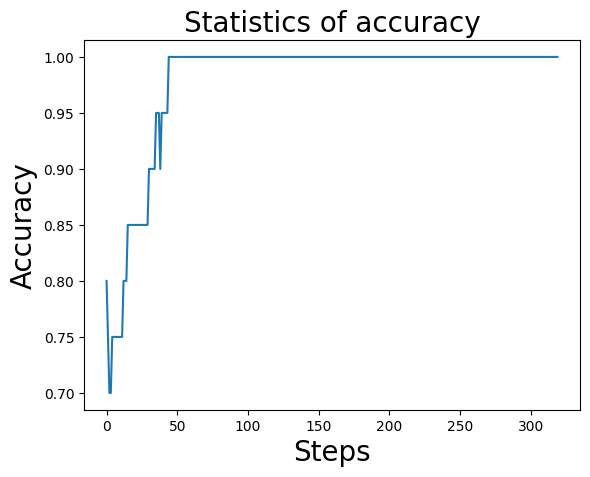

In [12]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

As can be seen from the above printed image, after about 50 steps, the prediction accuracy has converged to 1, which means that the prediction accuracy has reached 100%.

## Predicting

Finally, we test the trained model and apply it on the test set.

In [13]:
from mindspore import ops                                                       # Import the ops module

predict = np.argmax(ops.Softmax()(model.predict(ms.Tensor(X_test))), axis=1)    # Using the established model and test samples, get the classification predicted by the test samples
correct = model.eval(test_loader, dataset_sink_mode=False)                      # Calculate the prediction accuracy of the trained model applied to the test sample

print("Predicted classification result: ", predict)                             # For test samples, print the predicted classification result
print("Actual classification result: ", y_test)                                 # For test samples, print the actual classification result

print(correct)                                                                  # Print the accuracy of model predictions

Predicted classification result:  [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
Actual classification result:  [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
{'Acc': 1.0}


It can be seen from the above print that the predicted classification results are completely consistent with the actual classification results, and the accuracy of the model prediction has reached 100%.

So far, we have experienced how to build a quantum neural network to solve a classic problem in classical machine learning - the iris classification problem. I believe everyone has a better understanding of using MindSpore Quantum! Looking forward to digging more questions and giving full play to the powerful functions of MindSpore Quantum!

In [14]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')